In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
#Load and Prepare Data
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
df['BinaryDiabetes'] = df['Diabetes_012'].apply(lambda x: 0 if x == 0 else 1)

# We only want first 15000: for run time purposes
df = df.iloc[:15000]
X = df.drop(['Diabetes_012', 'BinaryDiabetes'], axis=1).values
y = df['BinaryDiabetes'].values.reshape(-1, 1)

# Normalize 
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# Split (80/20)
split_idx = int(0.8 * len(X_norm))
X_train, X_test = X_norm[:split_idx], X_norm[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]



In [52]:
#Logistic Regression
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def train_logistic_regression(X, y, lr=0.01, epochs=300):
    n_samples, n_features = X.shape
    weights = np.zeros((n_features, 1))
    bias = 0

    for _ in range(epochs):
        z = np.dot(X, weights) + bias
        y_pred = sigmoid(z)

        dw = np.dot(X.T, (y_pred - y)) / n_samples
        db = np.mean(y_pred - y)

        weights -= lr * dw
        bias -= lr * db

    return weights, bias

def predict_logistic(X, weights, bias, threshold=0.5):
    probs = sigmoid(np.dot(X, weights) + bias)
    return (probs >= threshold).astype(int), probs

# Train and Predict
weights, bias = train_logistic_regression(X_train, y_train)
y_pred, y_proba = predict_logistic(X_test, weights, bias)

accuracy = (y_pred == y_test).mean()
loss = compute_loss(y_test, y_proba)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

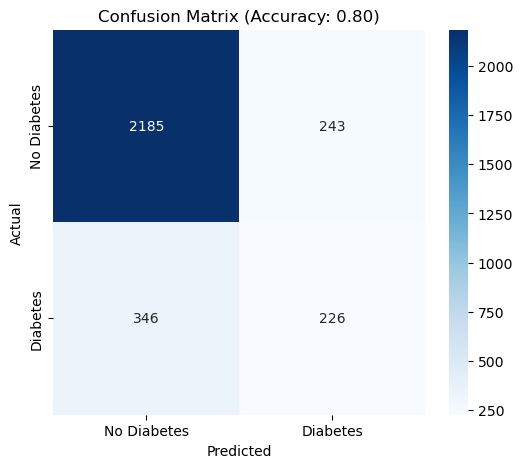

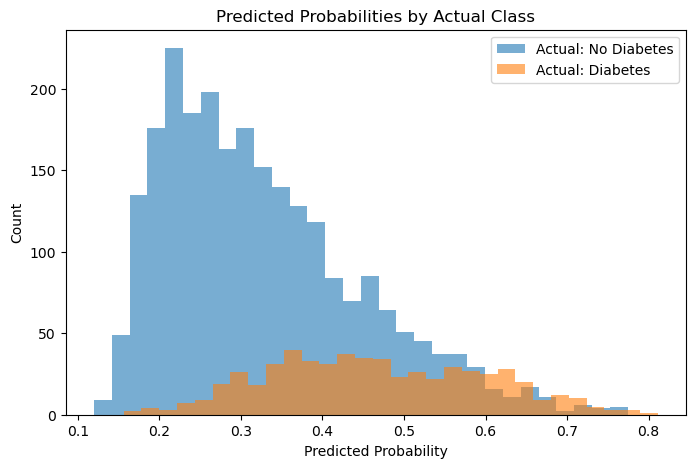

C:\Users\minac\AppData\Local\Temp\ipykernel_29000\1556108259.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Diabetes (1 = Has/Pre, 0 = None)")


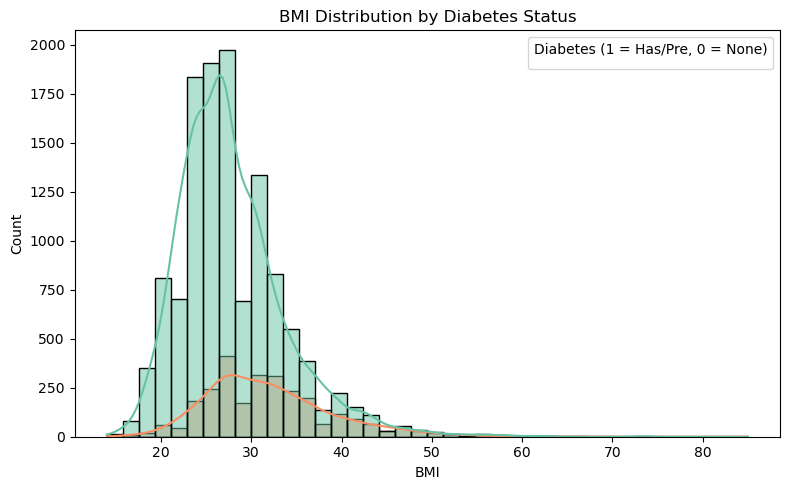

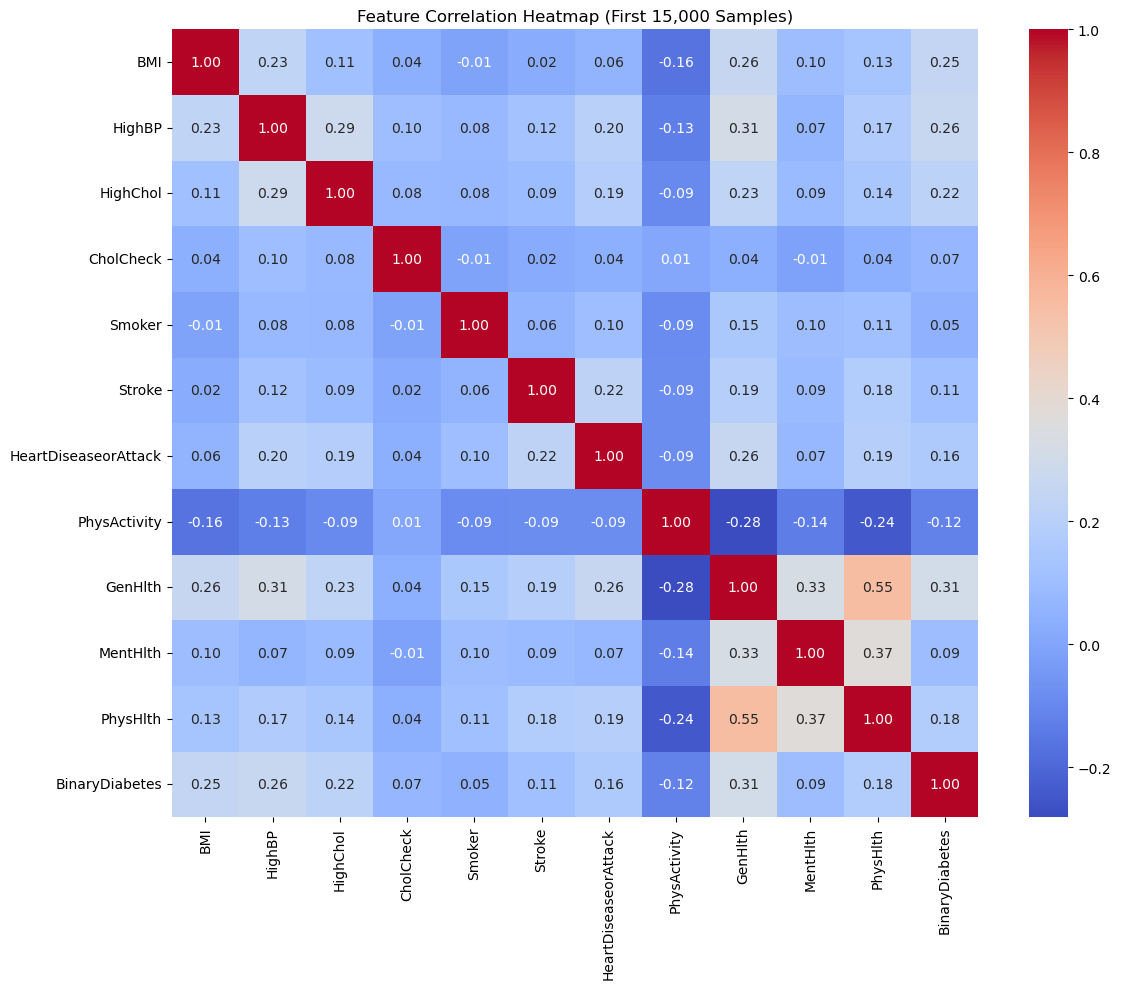

In [53]:
# Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2f})")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(y_proba[y_test.flatten() == 0], bins=30, alpha=0.6, label='Actual: No Diabetes')
plt.hist(y_proba[y_test.flatten() == 1], bins=30, alpha=0.6, label='Actual: Diabetes')
plt.title("Predicted Probabilities by Actual Class")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="BMI", hue="BinaryDiabetes", bins=40, kde=True, palette="Set2")
plt.title("BMI Distribution by Diabetes Status")
plt.xlabel("BMI")
plt.ylabel("Count")
plt.legend(title="Diabetes (1 = Has/Pre, 0 = None)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
selected_features = ['BMI', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
                     'PhysActivity', 'GenHlth', 'MentHlth', 'PhysHlth']
corr = df[selected_features + ['BinaryDiabetes']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap (First 15,000 Samples)")
plt.tight_layout()
plt.show()

In [54]:
# K-NN
def initialize_centroids(X, k):
    np.random.seed(42)
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    return np.array([X[labels == i].mean(axis=0) for i in range(k)])

def k_means(X, k=2, max_iters=100):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return labels, centroids

kmeans_labels, kmeans_centroids = k_means(X_norm, k=2)

from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(X_norm)

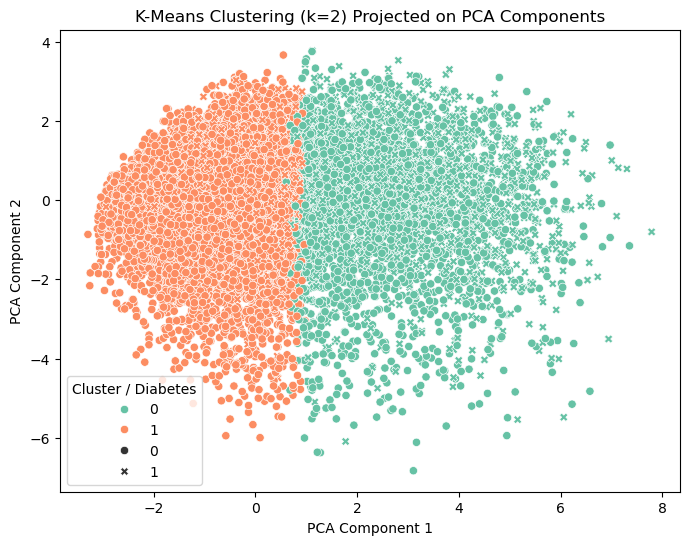

,Metric,Value
0,Accuracy (LogReg),0.803667
1,Loss (LogReg),0.489436


In [55]:
#Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='Set2', style=df['BinaryDiabetes'][:15000])
plt.title("K-Means Clustering (k=2) Projected on PCA Components")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster / Diabetes")
plt.show()

# Display summary
summary_df = pd.DataFrame({
    "Metric": ["Accuracy (LogReg)", "Loss (LogReg)"],
    "Value": [accuracy, loss]
})

from IPython.display import display
display(summary_df)